### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

## Notebook - Modelagem

In [1]:
from libraries import *
from funcoes_churn import *

In [2]:
# READING DATA

data_churn = pd.read_csv('../dataRaw/customer_churn.csv', index_col = 'customerID')

In [3]:
# TRATAMENTO DOS DADOS

data_churn_ = data_churn.copy()
data_churn_ = Tratamento.alteraTipoDado(data_churn_, columns = ['TotalCharges', 'MonthlyCharges'])
data_churn_ = Tratamento.fillNa(data_churn_, column = 'TotalCharges')
data_churn_ = Tratamento.alteraValores(df = data_churn_
                                       ,columns = ['MultipleLines'
                                                   ,'OnlineSecurity'
                                                   ,'OnlineBackup'
                                                   ,'DeviceProtection'
                                                   ,'TechSupport'
                                                   ,'StreamingTV'
                                                   ,'StreamingMovies'
                                                   ]
                                       ,dictToMap = {'No internet service': 'No'
                                                    ,'No phone service': 'No'})

data_churn_ = Tratamento.alteraValores(df = data_churn_
                                       ,columns = ['gender'                                            
                                                    , 'Partner'
                                                    , 'Dependents'                                                   
                                                    , 'PhoneService'
                                                    , 'MultipleLines'
                                                    , 'InternetService'
                                                    , 'OnlineSecurity'
                                                    , 'OnlineBackup'
                                                    , 'DeviceProtection'
                                                    , 'TechSupport'
                                                    , 'StreamingTV'
                                                    , 'StreamingMovies'
                                                    ,'PaperlessBilling'
                                                    ,'Churn'
                                                   ]
                                       ,dictToMap = {'No': '0'
                                                    ,'Yes': '1'
                                                    ,'Female': '1'
                                                    ,'Male': '0'})

data_churn_ = Tratamento.replaceCharacters(df = data_churn_)

In [4]:
# PREPARANDO DADOS PARA MODELAGEM

X_train, X_test, y_train, y_test = Modelagem().prepara_variaveis(df = data_churn_)

Quantidade de dados de treino: 2806
Quantidade de dados de teste: 1761


In [ ]:
# TREINANDO MODELO

In [7]:
modelTrained = Modelagem().trainModel(model = RandomForestClassifier(n_estimators=100, random_state=123)
                                     ,X=X_train
                                     ,y=y_train)

In [8]:
modelTrained

RandomForestClassifier(random_state=123)

In [ ]:
# FAZENDO A PREDICAO

In [9]:
prediction, y_pred = Modelagem().predicMetrics(modelTrained =modelTrained
                                      ,X_test = X_test
                                      ,y_test = y_test)

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1295
           1       0.51      0.73      0.60       466

    accuracy                           0.74      1761
   macro avg       0.70      0.74      0.71      1761
weighted avg       0.79      0.74      0.76      1761



Text(70.72222222222221, 0.5, 'Real')

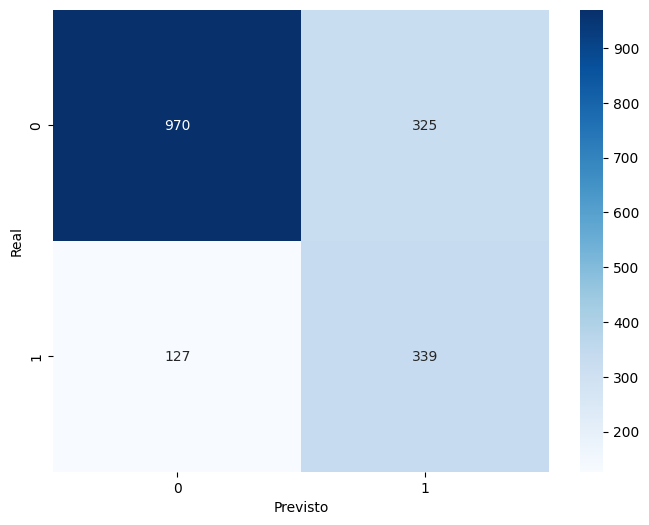

In [15]:
cm = confusion_matrix(y_test, y_pred)
class_labels = [0, 1]

# Cria um mapa de calor da matriz de confusão
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
heatmap.set_xlabel("Previsto")
heatmap.set_ylabel("Real")


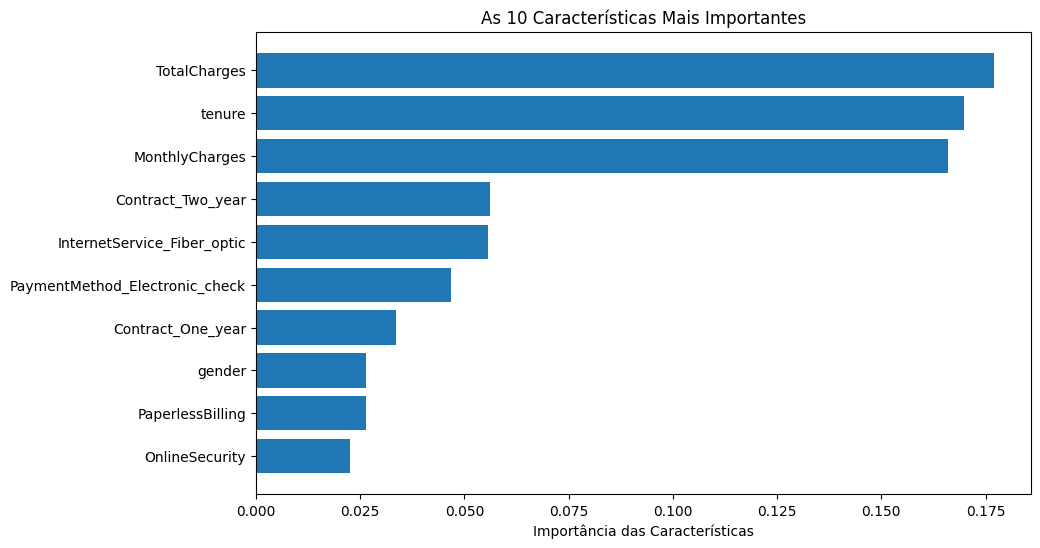

In [12]:
feature_importance = modelTrained.feature_importances_


feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
top_features = sorted_feature_importance[:10]
top_feature_names, top_feature_importance = zip(*top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_feature_importance)
plt.xlabel('Importância das Características')
plt.title('As 10 Características Mais Importantes')
plt.gca().invert_yaxis()  
plt.show()